#**Dynamic Programming - Cake Eating**



In this notebook we will use dynamic programming to solve
a simple cake eating problem.


![Photo by Alexander Dummer from Pexels](https://drive.google.com/uc?id=1TnJZrjeOQDWFn7CcuXpHqSO-_2IJ2K6k)
(Photo by Alexander Dummer from Pexels)


You have 8 pieces of cake. You also have a hoggish roommate who will eat the
whole remaining cake with probability $p$ if there is some left.
You get a utility of $\sqrt{a}$ by eating $a$ pieces
and your discount factor is $\gamma = 0.9$

Calculate the optimal policy and the corresponding value function.





# **Model**


The number of pieces of cake $s$ is a discrete state variable:
- $s \in \{0, 1, 2, \dots, 8\}$


The action variable $a$ is the number of pieces of cake that were eaten:
- $a \in \{0, 1, 2, \dots, s\}$

The state transition function is:
- $t(s, a) = s - a - x$,

where $x$ is $s-a$ (the remaining cake) with probability $p$, else 0

The reward function is:
- $r(s, a) = \sqrt{a}$

# Environment

Import the necessary libraries and implement the cake eating environment.


In [1]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

Copy the basic structure from the Gym interface of an environment
([https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html))
call it CakeEatingEnv and implement the init, step and reset function.

init:
- define the action and state space
- define the probability that your roommate eats a piece of cake,
use a probability you consider appropriate
- define a random number generator

step:
- calculate the reward
- calculate the next state
- determine if we reached the terminal state

reset:
- set the initial state and return it

In [2]:
class CakeEatingEnv(gym.Env):
    """Custom Environment that follows gym interface."""
    metadata = {'render.modes': ['human']}

    def __init__(self, p=0.2):
        super(CakeEatingEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        n_actions = 9
        self.action_space = spaces.Discrete(n_actions)

        # In our simple model observation and state are synonyms
        self.initial_cake_size = 8
        self.observation_space = spaces.Discrete(self.initial_cake_size+1)

        # probability that your roommate eats the whole remaining cake
        self.p = p

        self.rng = default_rng()
        
        
    def step(self, action):
        """State transition of the model.

        Args:
            action (int): Number of pieces of cake eaten

        Returns:
            state (numpy.ndarray): A shape-() array
            reward (int): Reward signal, which is here the utility
            done (bool): Indicating if terminal state is reached
            info (dict): Infos for debugging

        """

        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        assert action <= self.state, "%r is to much extraction" % action


        reward = np.sqrt(action)

        # state transition
        self.state -= action

        if self.rng.random() < self.p:
            self.state = 0

        # This is a episodic task, so done is true if the cake is eaten
        done = self.state == 0

        info = {}

        return np.array(self.state), reward, done, info


    def reset(self):
        """Resets the environment

        Initializes the state variable

        Returns:
            state (numpy.ndarray): A shape-() array
        
        """
        self.state = self.initial_cake_size
                      
        return np.array(self.state)


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass


---


**Test the environment**


---


You can find the basic structure to simulate the environment in
the [Open AI documentation](https://gym.openai.com/docs/).
 




In [3]:
# create the environment
env = CakeEatingEnv()

# reset the environment
state = env.reset()

# create a list to store all states during the simulation
state_path = [state]

# loop over each time step in the episode
# use a policy to eat only 1 piece of cake every period
done = False
while not done:
    action = 1
    state, reward, done, _ = env.step(action)
    
    state_path.append(state)



---

**Plot the episode**


---



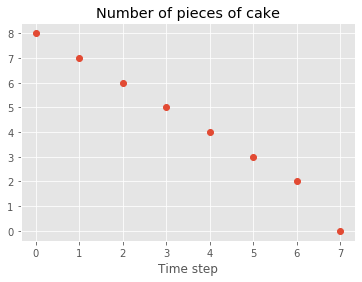

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel('Time step')
ax.set_title('Number of pieces of cake')

ax.plot(state_path, 'o');

# **Policy Evaluation**

Evaluate this policy ($\pi(s) = 1$ for all $s$) using the policy
evaluation algorithm. Write a function which implements the policy
evaluation algorithm.

In [5]:
def evaluate_policy(env, V, policy, gamma, eps=1e-8, max_iter=1000):
    """Implements the policy evaluation algorithm
    
    Calculates the corresponding value function of a policy

    Args:
        env (class): MineManagement Environment
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
        policy (numpy.ndarray): A shape-(num_states,) array, defines the action
            for every state
        gamma (float): Discount factor
        eps (float): Error tolerance for stopping the iteration
        max_iter (int): Maximum number of iteration if process doesn't converge

    Returns:
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
    
    """

    n_states = env.observation_space.n


    for _ in range(max_iter):
        # save value function to check for convergence later
        V_old = V.copy()

        # one iteration step for all states
        V = np.sqrt(policy) + gamma*(env.p*V[0]
                                  + (1-env.p)*V[np.arange(n_states) - policy])

        # check for convergence
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break
    
    return V   


In [6]:
# create environment and reset it
env = CakeEatingEnv()
env.reset()

# define policy to evaluate
policy = np.ones(env.action_space.n, dtype=np.int8)
policy[0] = 0

# init value function
V = np.zeros(env.observation_space.n)

# discount factor
gamma = 0.9

# evaluate policy
V = evaluate_policy(env, V, policy, gamma)



---

**Plot the value function**


---



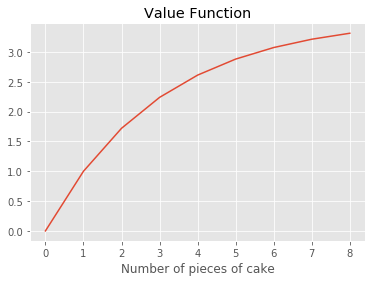

In [7]:
_, ax = plt.subplots()

ax.set_xlabel('Number of pieces of cake')
ax.set_title('Value Function')

ax.plot(V)


# **Value Iteration**

Implement the value iteration algorithm.

In [8]:
def value_iteration(env, gamma, eps=1e-8, max_iter=1000):
    """Implements the value iteration algorithm

    Calculates the optimal policy and optimal value function

    Args:
        env (class): OpenAI gym environment
        gamma (int): Discount factor
        eps (float): Error tolerance
        max_iter (int): Maximum number of iteration
    """
    # save number of states
    n_states = env.observation_space.n

    # initialize value function
    V = np.zeros(n_states)

    # iterate until value function converges
    for _ in range(max_iter):
        V_old = V.copy()
        for state in range(n_states):
            possible_actions = np.array([a for a in range(state+1)])
            V[state] = np.max(np.sqrt(possible_actions)
                          + gamma * (env.p * V[0]
                                     + (1-env.p) * V[state-possible_actions]))

        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break

    policy = np.zeros(n_states, dtype=np.int8)
    for state in range(n_states):
        possible_actions = np.array([a for a in range(state+1)])
        policy[state] = np.argmax(np.sqrt(possible_actions)
                              + gamma * (env.p*V[0]
                                         +(1-env.p)*V[state-possible_actions]))

    return V, policy



In [9]:
# create environment and reset it
env = CakeEatingEnv(0.1)
env.reset()

# discount factor
gamma = 0.9

# apply policy iteration
V, policy = value_iteration(env, gamma)


---

**Plot the value function and policy function**


---


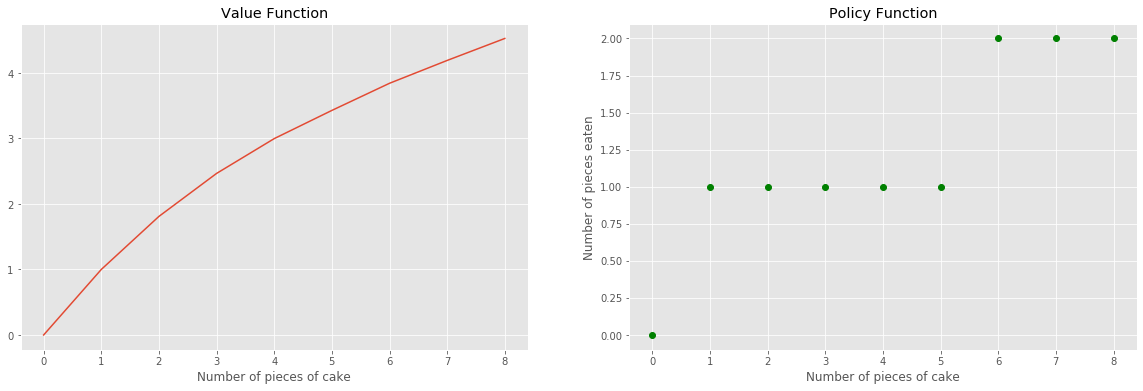

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# plot value function
ax[0].set_xlabel('Number of pieces of cake')
ax[0].set_title('Value Function')

ax[0].plot(V)

# plot policy function
ax[1].set_xlabel('Number of pieces of cake')
ax[1].set_ylabel('Number of pieces to eat')
ax[1].set_title('Policy Function')

ax[1].plot(policy, 'go');

Let's simulate an episode with the optimal policy.

In [11]:
state = env.reset()

state_path = [state]

done = False
while not done:
    action = policy[state]
    state, reward, done, _ = env.step(action)
    
    state_path.append(state)

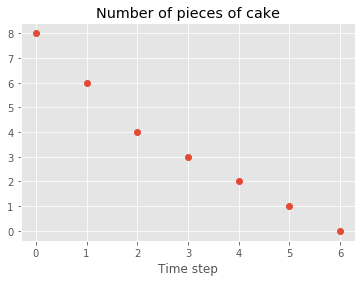

In [12]:
fig, ax = plt.subplots()

ax.set_xlabel('Time step')
ax.set_title('Number of pieces of cake')

ax.plot(state_path, 'o');